# CTA data analysis with Gammapy

## Caveat

* This notebook was prepared in a hurry, it is incomplete.
* The CTA first data challenge (1DC) data is still in preparation.
* Accessing background models doesn't work yet with Gammapy
* Several other small known issues with the data and Gammapy.
* Work in progress ... please excuse the mess!

## Introduction

The focus of this notebook is on demonstrating how to quickly perform a standard analysis of a given target in the sky. The gammapy functions and classes that we'll use won't be explained in detail. Please refer to the other gammapy tutorial notebooks, if you're interested.

At some point there should be a convenience class to make this kind of analysis easier, feedback on how this should be implemented is welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions, if something goes wrong here you won't be able to run the notebook
import gammapy
import numpy as np
import astropy
import regions
import sherpa
import uncertainties
import photutils

print('gammapy:', gammapy.__version__)
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('regions:', regions.__version__)
print('sherpa:', sherpa.__version__)
print('uncertainties:', uncertainties.__version__)
print('photutils:', photutils.__version__)

gammapy: 0.7.dev4697
numpy: 1.12.1
astropy: 2.0.dev18458
regions: 0.2
sherpa: 4.9.0+28.gaa98d19.dirty-py3.6-macosx-10.12-x86_64.egg
uncertainties: 2.4.8.1
photutils: 0.3.2


In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from photutils.detection import find_peaks
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator, ReflectedRegionsBackgroundEstimator
from gammapy.utils.energy import EnergyBounds
from gammapy.detect import TSImageEstimator

In [4]:
# Setup the logger
import logging
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)

## Load Data

First, we have to load the CTA data exported to fits format (the format is described in detail [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/)).

In [5]:
DATA_DIR = '$GAMMAPY_EXTRA/test_datasets/cta_1dc'
# DATA_DIR = '/Users/deil/1dc/1dc.pre'

data_store = DataStore.from_dir(DATA_DIR)
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /Users/deil/code/gammapy-extra/test_datasets/cta_1dc
Rows: 10038
OBS_ID: 1 -- 1673
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Number of observations: 1673


In [6]:
print(data_store.obs_table.colnames)
obs_colnames = ['OBS_ID', 'DATE_OBS', 'TIME_OBS', 'GLON_PNT', 'GLAT_PNT']
data_store.obs_table[::100][obs_colnames]

['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE_OBS', 'TIME_OBS', 'DATE_END', 'TIME_END', 'EVENTS_FILENAME', 'EVENT_COUNT', 'EVENT_TIME_MIN', 'EVENT_TIME_MAX', 'EVENT_ENERGY_MIN', 'EVENT_ENERGY_MAX']


OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT
int64,str10,str8,float64,float64
1,2021-01-01,11:58:51,359.500044973,-0.500037206629
101,2021-01-06,14:38:51,359.850020073,-0.416645559074
201,2021-01-11,17:18:51,0.0999876586067,-0.333402059745
301,2021-01-16,19:58:51,0.449997382071,-0.250026911671
401,2021-01-22,12:30:51,359.749994512,-0.0833922689931
501,2021-01-27,15:10:51,359.999985804,-1.94251867121e-05
601,2021-02-01,17:50:51,0.34998366634,0.0832847289392
701,2021-02-06,20:30:51,359.650013181,0.249974821922
801,2021-02-12,13:02:51,359.900010511,0.333332196219


## Select observations

In [7]:
# I've only copied EVENTS for these three obs for testing
# Trying to access any other will fail!
obs_id = [659, 1398, 1320]
obs_list = data_store.obs_list(obs_id)

In [8]:
data_store.obs_table.select_obs_id(obs_id)[obs_colnames]

OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT
int64,str10,str8,float64,float64
659,2021-02-04,18:22:51,0.100058295405,0.166660969419
1398,2021-03-15,17:18:51,5.13611286693e-05,2.00001672658
1320,2021-03-11,16:14:51,3.07691727701,-0.66667119626


In [9]:
obs = obs_list[0]

In [10]:
print(obs)

Info for OBS_ID = 659
- Start time: 665735040.00
- Pointing pos: RA 266.30 deg / Dec -28.76 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 5.000 %



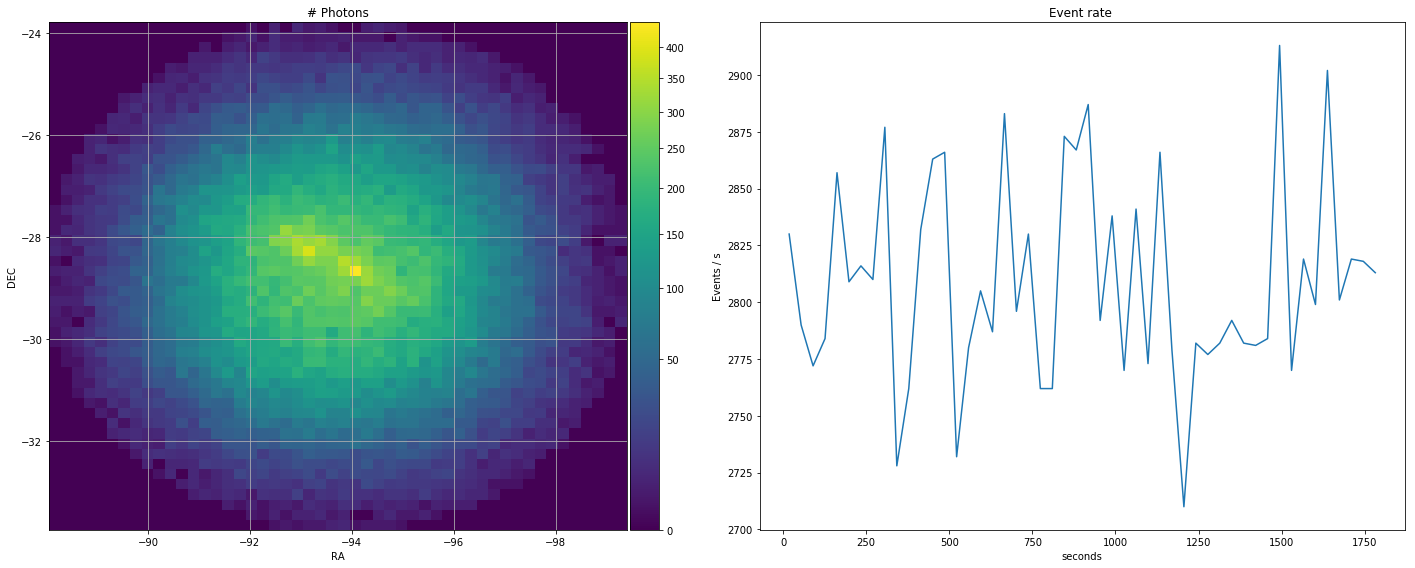

In [11]:
obs.events.peek()

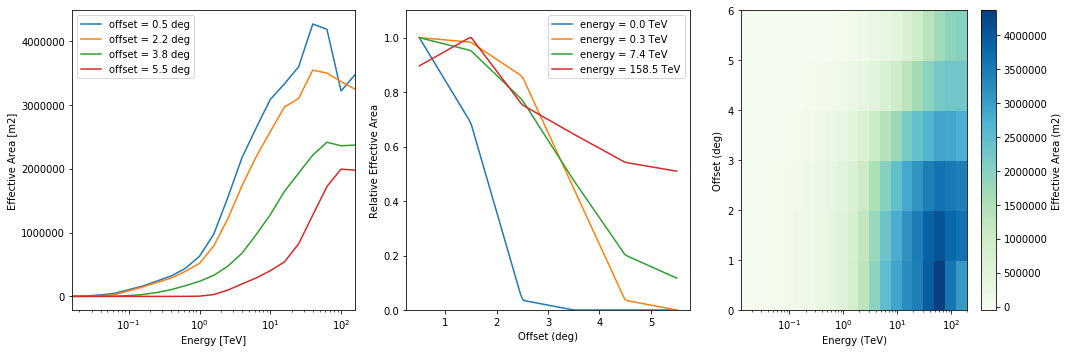

In [12]:
obs.aeff.peek()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:1152: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/Users/deil/Library/Python/3.6/lib/python/site-packages/astropy-2.0.dev18458-py3.6-macosx-10.12-x86_64.egg/astropy/units/quantity.py:1047: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:1113: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


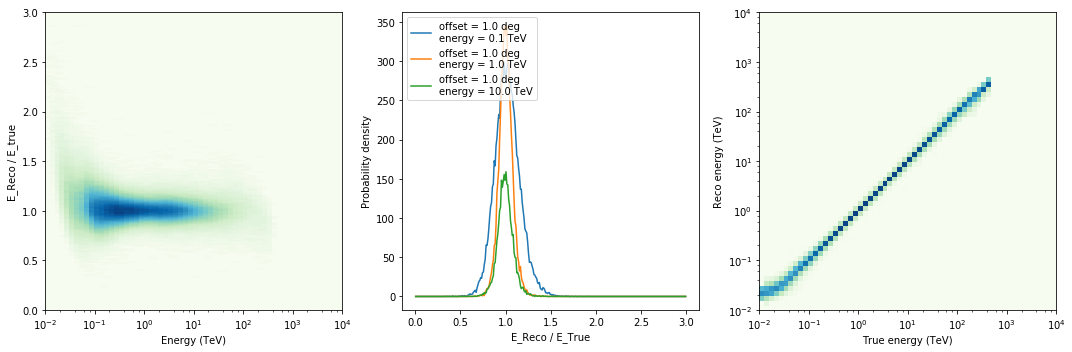

In [13]:
obs.edisp.peek()

/Users/deil/code/gammapy/gammapy/image/models/gauss.py:254: RuntimeWarning: invalid value encountered in true_divide
  self.norms /= self.integral
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


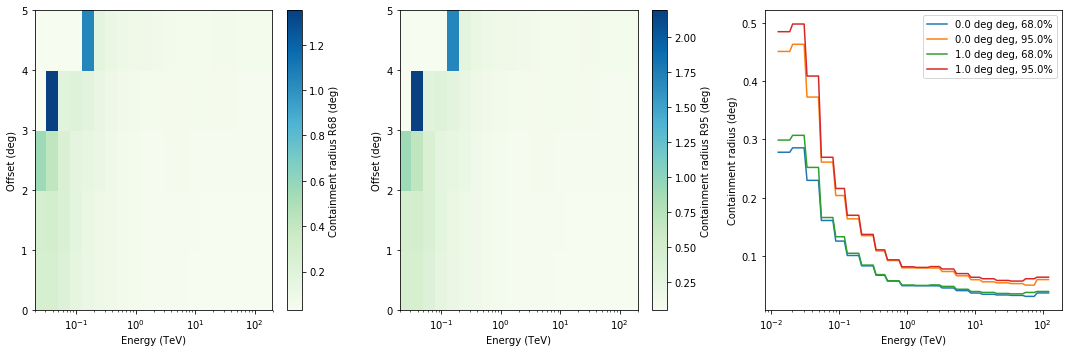

In [14]:
obs.psf.peek()

## Define inputs

Select the target position and define an ON region for the spectral analysis

In [15]:
target_position = SkyCoord(0, 0, unit='deg', frame='galactic')
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

In [16]:
# Define reference image centered on the target
xref = target_position.galactic.l.value
yref = target_position.galactic.b.value
# size = 10 * u.deg
# binsz = 0.02 # degree per pixel
# npix = int((size / binsz).value)

ref_image = SkyImage.empty(
    nxpix=800, nypix=600, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL',
)
print(ref_image)

Name: None
Data shape: (600, 800)
Data type: float64
Data unit: 
Data mean: 0.000e+00
WCS type: ['GLON-TAN', 'GLAT-TAN']



(<matplotlib.figure.Figure at 0x11764acc0>,
 None)

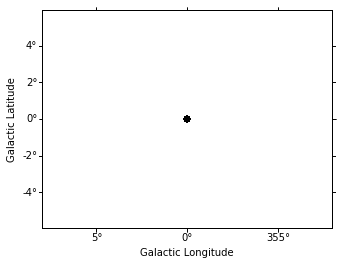

In [17]:
exclusion_mask = ref_image.region_mask(on_region)
exclusion_mask.data = 1 - exclusion_mask.data
exclusion_mask.plot()

## Make maps

Standard analysis products: Counts and Significance images

In [18]:
bkg_estimator = RingBackgroundEstimator(
    r_in=0.5 * u.deg,
    width=0.2 * u.deg,
)
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=100 * u.GeV,
    emax=100 * u.TeV,
    offset_max=3 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=exclusion_mask,
)
images = image_estimator.run(obs_list)
images.names

/Users/deil/code/gammapy/gammapy/cube/core.py:85: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2444: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/Users/deil/code/gammapy/gammapy/background/ring.py:321: RuntimeWarning: invalid value encountered in true_divide
  result['alpha'] = SkyImage(data=exposure_on.data / result['exposure_off'].data, wcs=wcs)
/Users/deil/code/gammapy/gammapy/image/models/gauss.py:254: RuntimeWarning: invalid value encountered in true_divide
  self.norms /= self.integral


['counts', 'exposure', 'background', 'excess', 'flux', 'psf']

In [19]:
def show_image(image, radius=3, vmin=0, vmax=3):
    """Little helper function to show the images for this application here."""
    image.smooth(radius=radius).show(vmin=vmin, vmax=vmax, add_cbar=True)
    image.cutout(
        position=SkyCoord(0.5, 0, unit='deg', frame='galactic'),
        size=(2*u.deg, 3*u.deg),
    ).smooth(radius=radius).show(vmin=vmin, vmax=vmax, add_cbar=True)

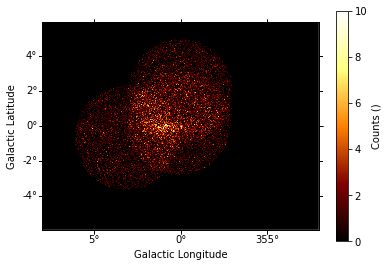

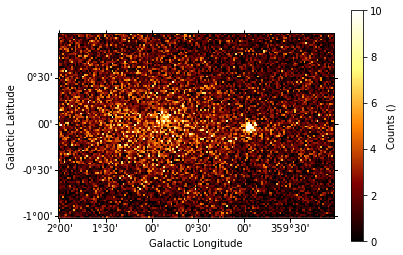

In [20]:
show_image(images['counts'], radius=0, vmax=10)

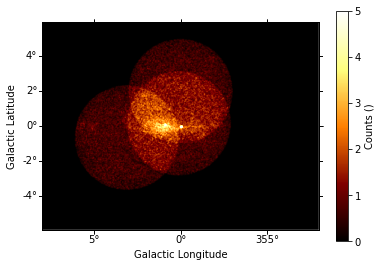

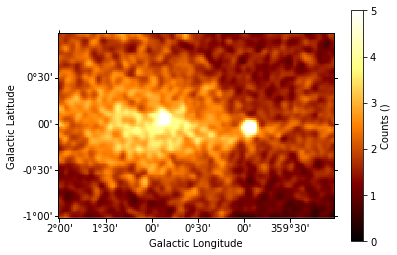

In [21]:
show_image(images['counts'], vmax=5)

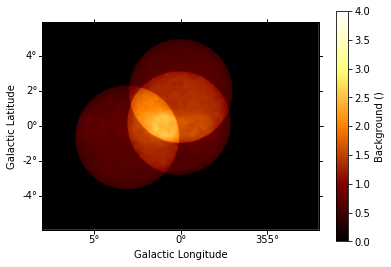

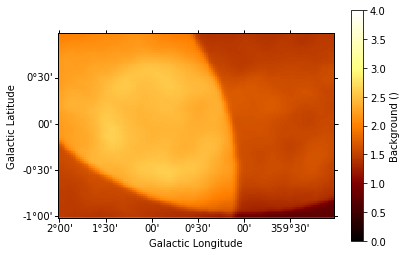

In [22]:
show_image(images['background'], vmax=4)

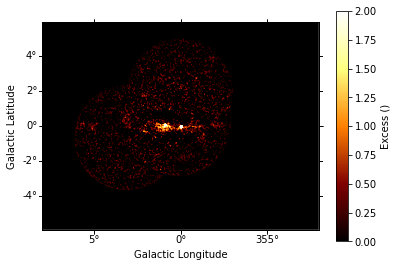

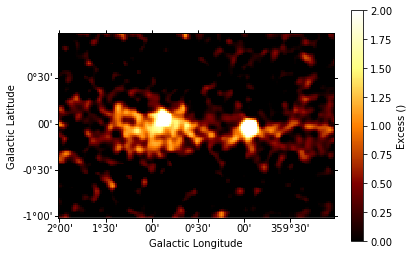

In [23]:
show_image(images['excess'], vmax=2)

/Users/deil/code/gammapy/gammapy/stats/poisson.py:254: RuntimeWarning: divide by zero encountered in true_divide
  term_b = sqrt(n_on * log(n_on / mu_bkg) - n_on + mu_bkg)


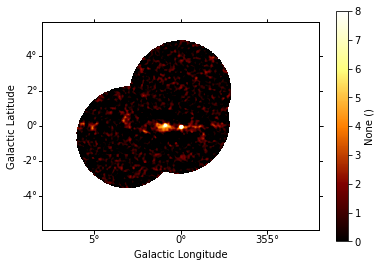

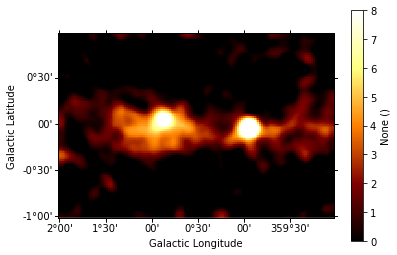

In [24]:
# Significance image
# Just for fun, let's compute it by hand ...
from astropy.convolution import Tophat2DKernel
kernel = Tophat2DKernel(4)
kernel.normalize('peak')

counts_conv = images['counts'].convolve(kernel.array)
background_conv = images['background'].convolve(kernel.array)

from gammapy.stats import significance
significance_image = SkyImage.empty_like(ref_image)
significance_image.data = significance(counts_conv.data, background_conv.data)
show_image(significance_image, vmax=8)

## Source Detection

Use the class [TSImageEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.compute_ts_image.html#gammapy.detect.TSImageEstimator.html) and [photutils.find_peaks](http://photutils.readthedocs.io/en/stable/api/photutils.find_peaks.html) to detect point-like sources on the images:

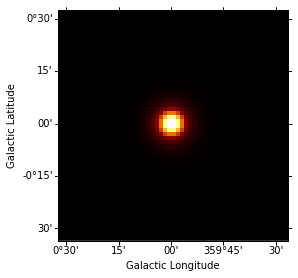

In [25]:
# cut out smaller piece of the PSF image to save computing time
# for covenience we're "misusing" the SkyImage class represent the PSF on the sky.
kernel = images['psf'].cutout(target_position, size= 1.1 * u.deg)
kernel.show()

In [26]:
ts_image_estimator = TSImageEstimator()
images_ts = ts_image_estimator.run(images, kernel.data)
print(images_ts.names)

['ts', 'sqrt_ts', 'flux', 'flux_err', 'niter']


In [27]:
# find pointlike sources with sqrt(TS) > 5
sources = find_peaks(data=images_ts['sqrt_ts'].data, threshold=5, wcs=images_ts['sqrt_ts'].wcs)
sources

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


x_peak,y_peak,icrs_ra_peak,icrs_dec_peak,peak_value
,,deg,deg,
int64,int64,float64,float64,float64
296,284,267.915952381,-27.3231654812,5.12550110261
145,292,269.453154512,-24.6469180992,5.3451004168
342,295,267.170472293,-27.9994641575,6.67910290233
403,297,266.412084142,-29.0219766936,22.7685818024
368,298,266.807286848,-28.4135026651,6.83271200754
357,301,266.878384099,-28.1942660011,13.5653260856


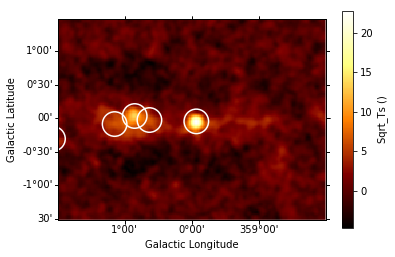

In [28]:
# Plot sources on top of significance sky image
images_ts['sqrt_ts'].cutout(
    position=SkyCoord(0, 0, unit='deg', frame='galactic'),
    size=(3*u.deg, 4*u.deg)
).plot(add_cbar=True)

plt.gca().scatter(
    sources['icrs_ra_peak'], sources['icrs_dec_peak'],
    transform=plt.gca().get_transform('icrs'),
    color='none', edgecolor='white', marker='o', s=600, lw=1.5,
)

# Spectrum

Standard analysis products: Spectrum and flux points

/Users/deil/code/gammapy/gammapy/background/reflected.py:122: RuntimeWarning: invalid value encountered in arcsin
  min_ang = Angle(2 * np.arcsin(self._pix_region.radius / self._offset), 'rad')


(<matplotlib.figure.Figure at 0x1176b4f98>,
 None)

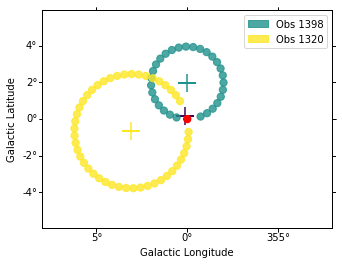

In [29]:
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    obs_list=obs_list,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot()

In [30]:
extract = SpectrumExtraction(
    obs_list=obs_list,
    bkg_estimate=bkg_estimate,
)
extract.run()

In [31]:
model = models.PowerLaw(
    index = 2 * u.Unit(''),
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

fit = SpectrumFit(extract.observations, model)
fit.fit()
fit.est_errors()
print(fit.result[0])

/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:198: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:199: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))



Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit      min  max  frozen
	--------- --------- --------- --------------- ---- ---- ------
	    index 1.775e+00 3.428e-02                    0 None  False
	amplitude 2.133e-12 1.993e-13 1 / (cm2 s TeV)    0 None  False
	reference 1.000e+00 0.000e+00             TeV None None   True

Covariance: 

	name/name  index   amplitude
	--------- -------- ---------
	    index  0.00118  2.03e-15
	amplitude 2.03e-15  3.97e-26 

Statistic: 153.318 (wstat)
Fit Range: [  1.00000000e-02   1.00000000e+02] TeV



In [32]:
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit.result[0].model,
)
fpe.compute_points()
fpe.flux_points.table

*** Observation summary report ***
Observation Id: [1398-1320]
Livetime: 0.950 h
On events: 1079
Off events: 23794
Alpha: 0.030
Bkg events in On region: 705.60
Excess: 373.40
Excess / Background: 0.53
Gamma rate: 0.09 1 / min
Bkg rate: 0.17 1 / min
Sigma: 12.81
energy range: 0.01 TeV - 100.00 TeV


/Users/deil/code/gammapy/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/Users/deil/code/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:198: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:199: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))


e_ref,e_min,e_max,dnde,dnde_err
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64
1.6681005372,1.13646366639,2.44843674682,1.07595477519e-12,2.08518011693e-13
3.83118684956,2.44843674682,5.99484250319,2.20441580634e-13,3.84589378647e-14
9.3804186664,5.99484250319,14.6779926762,3.41882661503e-14,7.6013900135e-15
22.9673617634,14.6779926762,35.938136638,2.63173941872e-15,1.22361047306e-15


(<matplotlib.axes._subplots.AxesSubplot at 0x117359a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11977a2b0>)

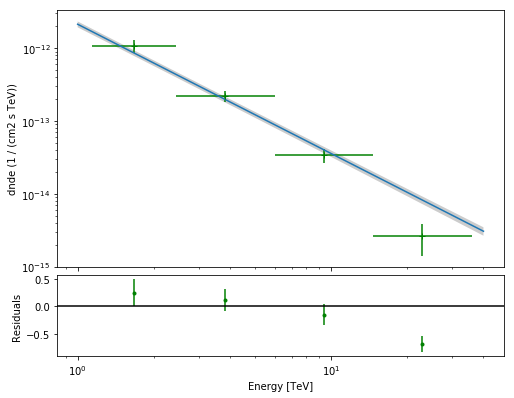

In [33]:
total_result = SpectrumResult(
    model=fit.result[0].model,
    points=fpe.flux_points,
)

total_result.plot(
    energy_range = [1, 40] * u.TeV,
    fig_kwargs=dict(figsize=(8,8)),
    point_kwargs=dict(color='green'),
)

## What next?

* Give us a few weeks to fix things up with the 1DC data and Gammapy.
* Go explore CTA 1DC!